# Regressão linear regularizada e Bias-Variance Tradeoff

## Introdução

<b>Disciplina: </b> Tópicos especiais de Física.

<b>Professor: </b> Saulo D. S. Reis (Departamento de Física -- UFC).

Nesta tarefa, você implementará uma regressão linear regularizada e a usará para estudar modelos com diferentes propriedades de <i>viés-variância</i>.

Toda a informação para a implementação necessária para resolver esta tarefa está neste notebook, e toda a sua implementação será feita neste notebook.

Estas tarefas foram adaptadas das tarefas originais presentes no exelente curso introdutório de Machine Learning do Prof. Andrew Ng, presente no Coursera que podem ser encontrados nesse [link](https://www.coursera.org/learn/machine-learning).

In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install scipy
#!pip install scikit-learn

In [2]:
# Usado para manipular os diretórios do sistema operacioal
import os

# Usada para operações numéricas e com vetores em python
import numpy as np

# Usada para plots
from matplotlib import pyplot

# Módulo de otimização do scipy
from scipy import optimize

# Usado para abrir arquivos do MATLAB de extensão mat
from scipy.io import loadmat

# Biblioteca escrita para esta tarefa com funções adicionais
import utils

# plote as figuras dentro deste jupyter notebook
%matplotlib inline



## Avaliação

Após completar essa tarefa, se certifique de submetê-la dentro do prazo.

A distribuição de pontos será feita de acordo com a tabela abaixo:

**Tarefas**


| Seção | Parte                                           |Função                     | Pontos 
|---------|:-                                             |:-                                     | :-: 
| 1       | [Função custo regularizada para a regressão linear](#section1)      | [`linearRegCostFunction`](#linearRegCostFunction) |  25    |
| 2       | [Gradiente para a regressão lienar regularizada](#section2)           | [`linearRegCostFunction`](#linearRegCostFunction) |25      |
| 3       | [Curvas de aprendizado](#section3)                                   | [`learningCurve`](#func2)         | 20     |
| 4       | [Mapeamento de features polinomial](#section4)                       | [`polyFeatures`](#polyFeatures)          | 10     |
| 5       | [Curva de validação](#section5)                           | [`validationCurve`](#validationCurve)       | 20     |   
|   Total de pontos    | $~$                                     |  $~$  | 100    




<a id="section1"></a>
## 1 Regressão lienar regularizada

Na primeira metade dessa tarefa, você implementará uma regressão linear regularizada para prever o volume de água vazando de uma barragem utilizando a variação no nível da água de um reservatório. Na segunda metade, você executará algumas estratégias de diagnóstico de algoritmos de <i> machine learning</i> e avaliará efeitos de viés versus variância.

### 1.1 Visualizando o conjunto de dados

Começaremos visualizando o conjunto de dados históricos da varaiação no nível da água, $x$, e a quantidade de vazão  de água dessa represa, $y$. Esse conjunto de dados é divido em três partes:

- Um **conjunto de treino** para o treino em: `X`, `y`
- Um **conjunto de validação** utilizado para determinar o parâmetro de regularização: `Xval`, `yval`
- Um **conunto de teste** para avaliarmos a performance. Estas são amostras "não vistas" pelo modelo durante o treino do modelo: `Xtest`, `ytest`

Execute a próxima célula para visualizar o conjunto de dados. Nas próximas partes da tarefa você implementará um algoritmo de regressão linear e a usará para ajustar uma reta ao dado e visualizar curvas de aprendizado. Seguido a isso, você implementará features polinomiais para encontrar um melhor ajuste ao dado.

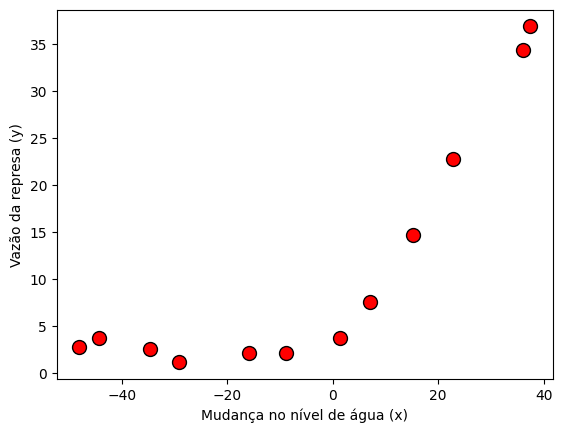

In [3]:
# Carrega dados de data1.mat, onde as variáveis estão guardadas em dicionários
data = loadmat(os.path.join('Data', 'data1.mat'))

# Extrai conjunto de treino, validação e teste do dicionário
# Converte y's de uma matriz 2D (formato do MATLAB) para um  vetor do numpy
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

# m = Número de amostras de treino
m = y.size

# Visualiza dados
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1)
pyplot.xlabel('Mudança no nível de água (x)')
pyplot.ylabel('Vazão da represa (y)');

### 1.2 Função custo regularizada para a regressão linear

Lembre-se de que a função custo regularizada para uma regressão linear é dada por:

$$ J(\Theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h\left(\Theta, x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right),$$

onde $\lambda$ é o parâmetro de regularização (ajudando assim a evitar sobreajuste). O termo de regularização coloca uma penalidade sobre o custo $J$. Se os valores dos parâmetros $\theta_j$ aumentam, a penalidade aumentará de acordo. Note que você não deve regularizar o termo $\theta_0$.

Agora, você deve completar o código para a função `linearRegCostFunction` na próxima célula. Lembre-se que sua implementação deve ser vetorizada.
<a id="linearRegCostFunction"></a>

In [4]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    """
    Calcula o custo e o gradiente da regressão linear regularizada
    com multiplos features.
    
    Parâmetros
    ----------
    X : tipo_array
        Conjunto de dados a ser ajustado. Uma matriz na forma 
        (m x n + 1) onde m é o número total de amostras de treino
        e n o número de features antes de adicionar o termo de 
        viés.
    
    y : tipo_array
        O valor da função para cada amostra. Um vetor na forma
        (n+1,).
    
    theta : tipo_array
        Parâmetros da regrssão linear. Um vetor na forma (n+1,).
    
    lambda_ : float, opcional
        Parâmetro de regularização.
    
    Saída
    -----
    J : float
        Valor da função custo. 
    
    grad : tipo_array
        Os valores do gradiente da função custo com respeito a
        theta. Um vator na forma (n+1,).
    
    Instruções
    ----------
    Calcule o custo e seu gradiente para uma regressão lienar 
    regularizada de um dado theta. Você deve atribuir o valor
    do custo a J e de seus gradietes a grad.
    """
    # Inicialize quatidades úteis
    m = y.size # Número de amostras de treino

    # Você precisa retornar as seguintes quantidades corretamente
    J = 0
    grad = np.zeros(theta.shape)

    ######### Custo Regularizado ##########
    # Erro quadrático médio # Regressão linear
    unreg_cost = (1 / (2*m)) * np.sum(np.square((np.dot(X,theta)) - y)) 
    # Termo de regularização # O viés não deve ser regularizado
    reg = (lambda_ / (2*m)) * np.sum(np.square(theta[1:]))
    # Custo regularizado
    cost = unreg_cost + reg
    
    ######### Gradiente Regularizado ##########
    # Gradiente da função custo
    grad = (np.dot((np.dot(X,theta)) - y,X))/m
    # Termo de regularização # O viés não deve ser regularizado
    reg_theta = theta.copy()
    reg_theta[0] = 0
    reg_grad = (lambda_ / m) * reg_theta
    # Gradiente regularizado
    grad += reg_grad

    return cost, grad

Após terminar sua implementação da função custo e seu gradiente, execute a próxima célula para calcular o custo de um `theta` inicializado em `[1, 1]`. Você deve encontrar o valor de saída 303.993.

In [5]:
theta = np.array([1, 1])
J, _ = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Custo em theta = [1, 1]: %f ' % J)
print('Esse valor deve ser igual a 303.993192)\n' % J)

Custo em theta = [1, 1]: 303.993192 
Esse valor deve ser igual a 303.993192)



<a id="section2"></a>
### 1.3 Gradiente para a regressão linear regularizado

De modo correspondente, as derivadas parciais da função custo para uma regressão linear regularizada é definida como:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left[ h\left(\Theta, x^{(i)} \right) - y^{(i)} \right] x_0^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left\{ \frac{1}{m} \sum_{i=1}^m \left[ h\left(\Theta, x^{(i)} \right) - y^{(i)} \right] x_j^{(i)} \right\} + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}.
$$

Na função custo [`linearRegCostFunction`](#linearRegCostFunction) acima, adicione o código para o cálculo do gradiente, retornando a quantidade `grad`. <font color='red'><b> Não se esqueça de reexecutar a célula contendo esta função para atualizar a definição da mesma.</b></font>

Após terminar sua implementação, utilize a próxima célula para executar sua implementação para a função gradiente utilizando um $\Theta$ inicializada em `[1, 1]`. Você deve encontrar um gradiente de `[-15.30, 598.250]`.

In [6]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Gradiente em theta = [1, 1]:  [{:.6f}, {:.6f}]'.format(*grad))
print('(Este valor deve ser igual a  [-15.303016, 598.250744])\n')

Gradiente em theta = [1, 1]:  [-15.303016, 598.250744]
(Este valor deve ser igual a  [-15.303016, 598.250744])



### Ajuste da regressão linear

Uma vez que sua função custo e gradiente estejam funcionando corretamente, execute o código em `trainLinearReg` (que você pode encontrar no arquivo `utils.py`) na próxima célula e tente ajustar os valores ótimos de `theta`. Essa função utiliza o módulo de otimização do `scipy` para minimizar a função custo.

Nesta parte do exercício, utilizaremos o parâmetro de regularização $\lambda$ igual a zero. Visto que nossa implementação tenta ajustar um $\Theta$ bidimensional, a regularização não será de muita ajuda para um $\Theta$ de dimensão tão baixa. Na próxima parte desta tarefa, você implementará uma regressão polinomial com regularização.

Além disto, o código na próxima célula deve produzir uma figura com o melhor ajuste, o qual deve ser similar à figura abaixo.

![](Figures/linear_fit.png)

O melhor ajuste encontrado para um $\Theta$ bidimensional nos diz que o modelo não é capaz de ajustar-se ao conjunto de treino, visto que este possui um padrão não linear. Se por um lado a visualização do conjunto de dados mostra-se como uma forma eficiente de identificar problemas com o nosso modelo, isso nem sempre é fácil, especialmente para casos em que possuímos um grande número de features. Na próxima seção, você implementará uma função para produzir curvas de aprendizado que ajudarão na tarefa de avaliar a qualidade do seu modelo, mesmo quando a visualização dos dados é difícil.

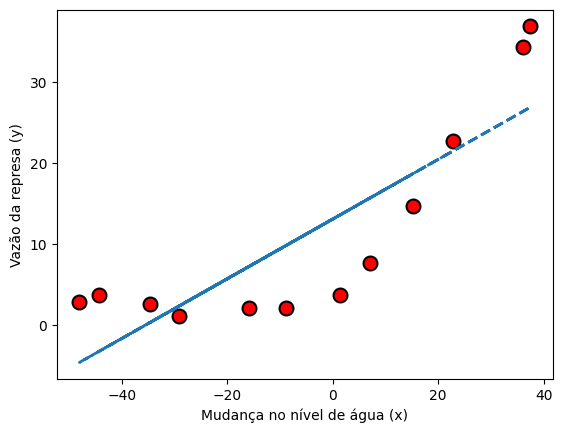

In [7]:
# Adiciona os termos de interceptação 
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = utils.trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

#  Visualiza o ajuste
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
pyplot.xlabel('Mudança no nível de água (x)')
pyplot.ylabel('Vazão da represa (y)')
pyplot.plot(X, np.dot(X_aug, theta), '--', lw=2);

<a id="section3"></a>
## 2 Bias-variance

Um conceito importante do aprendizado de máquina é o chamado bias-variance (viés-variância) tradeoff. Modelos com muito viés (bias) não são complexos o suficientes e tendem a sub-ajustar (underfit) o conjunto de treino, enquanto modelos com alta variância sobreajustam (overfit) o conjunto de treino.

Nessa parte da tarefa, você visualizará curvas de aprendizado e testará os error do modelo treinado para diagnosticar problemas de viés-variância.

### 2.1 Curvas de aprendizado

Agora, você implementará um código para produzir curvas de aprendizado que serão úteis durante o processo de debugging de algoritmo de aprendizado. Lembre-se que as curvas de aprendizado são o erro sobre o conjunto de treino e sobre o conjunto de validação como funções do número de amostras de treino utilizadas. Sua tarefa é completar a função `learningCurve` na próxima célula, de modo que ela retorne um vetor contendo os erros sobre os conjuntos de treino e validação.

Para imprimir curvas de aprendizado, precisamos dos erros dos conjuntos de treino e validação para conjuntos de treino de tamanhos diferentes. Para obter conjuntos de treino de tamanhos diferentes, você deve utilizar subconjuntos diferentes do conjunto de treino original `X`. Especificamente, para um conjunto de treino de tamanho $i$, você deve utilizar as primeiras $i$ amostras (ou seja, `X[:i,:]` e `y[:i]`).

Você pode utilizar a função `trainLinearReg` (chamando `utils.trainLinearReg(...)`) para encontrar os parâmetros $\Theta$. Note que `lambda_` é passado como um parâmetros
da função `learningCurve`. Após o treino do parâmetros $\Theta$, você deve calcular o erro dos conjuntos de treino e validação. Lembre-se que o erro para um conjunto de treino é definido por

$$ J_{\text{train}} = \frac{1}{2m} \left\{\sum_{i=1}^m \left[h\left(\Theta, x^{(i)} \right) - y^{(i)} \right]^2 \right\}. $$

Em particular, note que o erro do treino não inclui o termo de regularização. Um forma de calcular o erro do conjunto de treino é utilizando sua função custo com o parâmetro de regularização $\lambda = 0$ quando calcular o erro dos conjunto de treino e validação. Quando calculando o erro do conjunto de treino, certifique-se de que você está utilizando um subconjunto do mesmo (ou seja, `X[:n,:]` e `y[:n]`) ao invés de utilizar o conjunto de treino inteiro. Contudo, para o erro do conjunto de validação, você deve calcular o erro de validação sobre todo o conjunto de validação. Você deve guardar os erros calculados nos vetores `error_train` e `error_val`.

<a id="func2"></a>

In [8]:
# Utilizar a função custo como parâmetro de regularização lambda = 0

def learningCurve(X, y, Xval, yval, lambda_=0):
    """
    Calcula os erros de treino e validação necessários para a visualização
    das curvas de aprendizado.
    
    Nesta função, você calculará o erro de treino e validação para conjunto
    de dados de tamanhos de 1 até m. Na prática, quando trabalhando com 
    conjunto de dados muito grandes, você pode preferir trabalhar com
    intervalos maiores.
    
    Parâmetros
    ----------
    X : tipo_array
        Conjunto de treino. Uma matriz na forma (m x n + 1) onde m é o número
        de amostras de treino, e n o número de features antes da adição dos
        termos de interceptação.
    
    y : tipo_array
        Valores da função para cada amostra do conjunto de treino. Um vetor
        na forma (m, ).
    
    Xval : tipo_array
        Conjunto de validação. Uma matrix na forma (m_val X n +1) onde m_val
        é o número de amostras de validação, e n o número de features antes da
        adição dos termos de interceptação.
    
    yval : tipo_array
        Valores da função para cada amostra de validação. Um vetor na forma
        (m_val, ).
    
    lambda_ : float, optional
        Parâmetro de regularização.
    
    Saída
    -----
    error_train : tipo_array
        Um vetor na forma (m, ). error_train[i] contém o erro de i amostras de
        treino.
    error_val : tipo_array
        Um vetor na forma (m, ). error_val[i] contém o erro sobre o conjunto de
        validação de um modelo ajustado com i amostras de treino.
    
    Instruções
    ----------
    Preencha esta função para retornar os erros de treino em error_train e
    os erros de validação em error_val. Ou seja, error_train[i] e error_val[i]
    devem guardar o erro obtido utilizado um modelo treinado sobre i amostras
    de treino.
    
    Notas
    -----
    - Você deve calcular o erro de treino sobre as primeiras i amostras de treino,
      ou seja, X[:i,:] e y[:i].
      
      Para o erro de validação, você deve calcular o erro SOBRE TODO o conjunto de
      validação (Xval e yval).
    
    - Se você está utilizando a função custo (linearRegCostFunction) para calcular
      o erro de treino e de validação, você deve chamar essa função com o argumento 
      lambda_ igual a 0. 
      
    - Note que você ainda usará o parâmetro lambda para encontrar os valores dos 
    parâmetros tetha.
    
    Dica
    ----
    Você poderá fazer um loop sobre as amostras de treino:
    
            for i in range(1, m+1):
                # Calcule os erros de treino/validação usando exemplos
                # X[:i, :] e y[:i], guardando seus resultados em
                # error_train[i-1] e error_val[i-1]
               ....  
    """
    
    # Número de amostras de treino
    m = y.size

    # Você precisa retornar esses valores corretamente
    error_train_set = np.zeros(m)
    error_val_set   = np.zeros(m)
    
    # Loop sobre as amostras de treino
    for i in range(1, m+1):
        Xtest = X[:i,:]
        ytest = y[:i]
        
        theta = utils.trainLinearReg(linearRegCostFunction, Xtest, ytest, lambda_)

        error_train, g = linearRegCostFunction(Xtest, ytest, theta, lambda_=0.0)
        error_train_set[i-1] = error_train # Vetor com i amostras de treino
        
        error_val, g = linearRegCostFunction(Xval, yval, theta, lambda_=0.0)
        error_val_set[i-1] = error_val # Valores da função para cada amostra de validação
        
        #print(Xval)
        #print(yval)
    
    return error_train_set, error_val_set

Uma vez que você tenha implementado a função `learningCurve`, execute a próxima célula para visualizar as curvas de aprendizado. O resultado deve ser similar a figura abaixo.

![](Figures/learning_curve.png)

Na figura das curvas de aprendizado você deve perceber que ambos os erros sobre o conjunto de treino e o conjunto de validação são altos, mesmo quando aumentamos o número de amostras de treino. Isso é um sinal de que nosso modelo está sofrendo com um problema de viés - a regressão linear é muito simples e é incapaz de ajustar-se aos dados de forma apropriada. Na próxima sessão, você implementará uma regressão polinomial para obter um ajuste melhor.

# Amostras de treino	Erro treino	Erro validação
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


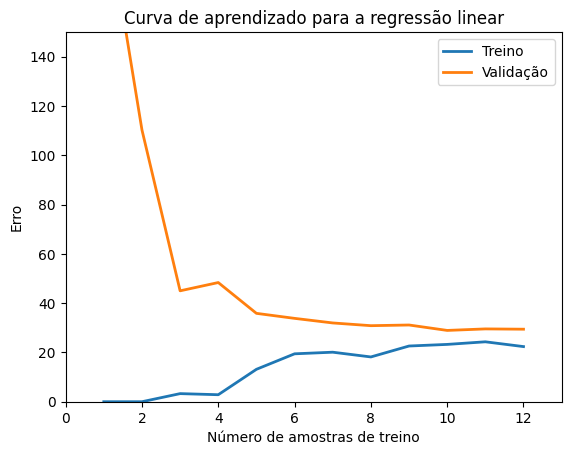

In [9]:
# Calcula o erro sobre os conjuntos de treino e validação utilizando diferentes
# tamanhos de conjunto de treino utilizando a função `learningCurve' 
error_train, error_val = learningCurve(np.concatenate([np.ones((m, 1)), X], axis=1),
                                       y,
                                       np.concatenate([np.ones((yval.size, 1)), Xval], axis=1),
                                       yval,
                                       lambda_=0)

# Visualiza curvas de aprendizado
pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Curva de aprendizado para a regressão linear')
pyplot.legend(['Treino', 'Validação'])
pyplot.xlabel('Número de amostras de treino')
pyplot.ylabel('Erro')
pyplot.axis([0, 13, 0, 150])

print('# Amostras de treino\tErro treino\tErro validação')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

<a id="section4"></a>

## 3 Regressão polinomial

O problema com nossa regressão linear é que ela é muito simples para nosso conjunto de dados, resultando em um sub-ajuste (alto viés). Nesta parte do nosso exercício, você abordará este problema adicionando mais features ao modelo. Para uma regressão polinomial, a nossa função hipótese será:

$$
\begin{align}
h\left(\Theta, x\right)  &= \theta_0 + \theta_1 \times (\text{nível do reservatório}) + \theta_2 \times (\text{nível do reservatório})^2 + \cdots + \theta_p \times (\text{nível do reservatório})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}.
$$

Note que ao definirmos $x_1 = (\text{nível do reservatório})$, $x_2 = (\text{nível do reservatório})^2$, $\cdots$ e $x_p = (\text{nível do reservatório})^p$, reduzimos nosso problema a um modelo de regressão linear onde os novos features são potencias do feature original (nível do reservatório).

Agora, você adicionará esses novos features utilizando potências do feature existente $x$ no nosso conjunto de dados. Sua tarefa nesta parte é completar o código da função `polyFeatures` na próxima célula. Essa função deve mapear o conjunto de treino original $X$ de tamanho $m\times 1$ em suas potências de maior grau. Especificamente, quando um conjunto de treino $X$ de tamanho $m\times 1$ é passado para a função `polyFeatures`, a função deve retornar uma matriz $m\times p$ `X_poly`, onde a primeira coluna guarda os valores originais de $X$, a segunda coluna guarda os valores $X^2$, a terceira os valores $X^3$, e assim por diante. Note que você não deve incluir termos de grau 0, visto que eles estão relacionados aos termos de interceptação dos vieses, os quais são adicionados à parte.

<a id="polyFeatures"></a>

In [10]:
def polyFeatures(X, p):
    """
    Mapeia X (vetor 1D) em uma matriz contendo potências de ordem
    p.
    
    Parâmetros
    ----------
    X : tipo_array
        Vetor de dados de tamanho m, onde m é o número de amostras
        de treino.
    
    p : int
        Ordem polinomial do mapeamento. 
    
    Saída 
    -----
    X_poly : tipo_array
        Uma matriz na forma (m x p, ), onde p é a ordem polinomial
        de X_poly e m o número de amostras de treino do conjunto
        de treino original X. Ou seja
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instruções
    ----------
    Dado um vetor X, retorna uma matriz X_poly onde a p-ésima coluna
    guarda a potência de ordem p do vetor X.\
    """
    # Você precisa retornar a seguinte quantidade corretamente.
    X_poly = np.zeros((X.shape[0], p))
    X_slice = X[:,0]
    
    for i in range(1, p+1): # Não se deve incluir termos de grau zero
        X_poly[:,i-1] = X_slice**i    

    return X_poly

Agora que você possui uma função que mapeia um vetor em dimensões superiores, execute a próxima célula para aplicá-la ao conjunto de treino, de validação e de teste.

In [11]:
p = 8

# Mapeia X em features polinomiais e normaliza
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = utils.featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Mapeia X_poly_val e normaliza, utilizando mu e sigma
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

# Mapeia X_poly_test e normaliza, utilizando mu e sigma
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

print('Amostra de treino 1 normalizada:')
X_poly[0, :]

Amostra de treino 1 normalizada:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

## 3.1 Treinando uma regressão polinomial

Após completar a função `polyFeatures`, prosseguiremos treinando a regressão polinomial usando sua função custo para a regressão linear.

Lembre-se que apensar de possuirmos termos polinomiais em nossa matriz, ainda estaremos resolvendo uma regressão linear. Os termos polinomiais podem ser considerados simplesmente como termos adicionais de uma regressão linear multi-dimensional. Assim, usaremos a mesma função implementada por você na primeira parte desta tarefa.

Aqui, usaremos um polinômio de grau 8. Depois de tudo, se executarmos o treinamento diretamente nos dados projetados, ele não funcionará muito bem, visto que os features estarão mal escalonados (por exemplo, uma amostra com $x = 40$ possuirá um feature com $x_8 = x^8 = 6.5\times 10^{12}$). Portanto, precisamos realizar uma normalização de features.

Antes do algoritmo aprender os parâmetros $\theta$ para a regressão polinomial, chamaremos primeiramente `featureNormalize` e reescalonaremos o conjunto de treino, quandando a média $\mu$, e o desvio padrão $\sigma$ separadamente. A função já está implementada em `utils.py` (é a mesma função da primeria tarefa).

Após o aprendizado dos parâmetros $\theta$, você verá dois plots gerados pela regressão polinomial com $\lambda = 0$, os quais devem ser similares aos seguintes plots:

<table>
    <tr>
        <td><img src="Figures/polynomial_regression.png"></td>
        <td><img src="Figures/polynomial_learning_curve.png"></td>
    </tr>
</table>

Você notará que o ajuste polinomial é capaz de seguir todos os pontos do dado muito bem, obtendo, assim, um erro de treino muito baixo. Na figura à direita, temos que o erro de treino mentém-se essencialmente igual a zero para todos os números de amostras de treino. Contudo, o ajuste polinomial é muito complexo e inclusive assume valores negativos. Isto indica que o modelo polinomial está sobreajustando os dados de treino e, assim, não irá generalizar mujito bem para novas amostras.

Para entendermos melhor os problemas de um modelo não-regularizado ($\lambda=0$), você pode ver que a curvas de aprendizado apresentam um erro de treino baixo e um erro de validação elevado, indicando um problema de alta variância.

Regressão polinomial (lambda = 0.000000)

# Amostras de treino	Erro treino	Erro validação
  	1		0.000000	160.721900
  	2		0.000000	160.121511
  	3		0.000000	59.071639
  	4		0.000000	77.998006
  	5		0.000000	6.448431
  	6		0.000000	10.828545
  	7		0.000000	27.929437
  	8		0.000000	21.489777
  	9		0.000298	33.312726
  	10		0.017177	49.686958
  	11		0.034879	30.762443
  	12		0.035627	25.921162


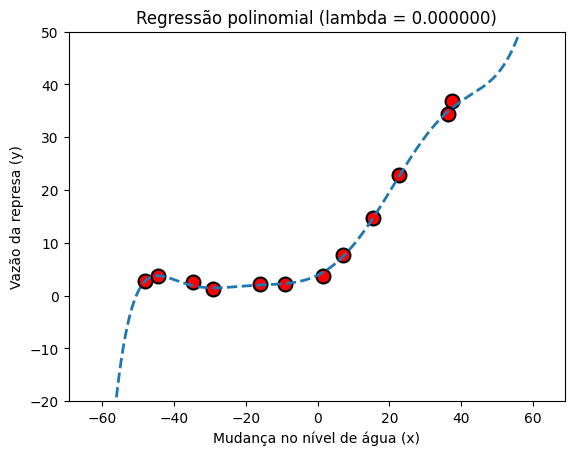

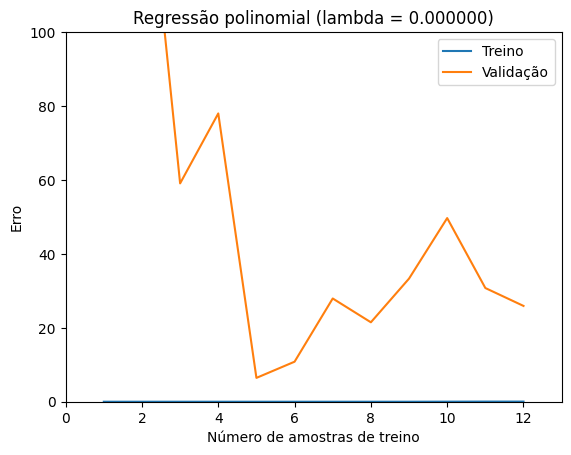

In [12]:
lambda_ = 0
theta = utils.trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=55)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

utils.plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Mudança no nível de água (x)')
pyplot.ylabel('Vazão da represa (y)')
pyplot.title('Regressão polinomial (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Regressão polinomial (lambda = %f)' % lambda_)
pyplot.xlabel('Número de amostras de treino')
pyplot.ylabel('Erro')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Treino', 'Validação'])

print('Regressão polinomial (lambda = %f)\n' % lambda_)
print('# Amostras de treino\tErro treino\tErro validação')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))